In [179]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import mpld3
from mpld3 import plugins
import os



In [262]:
def get_fear_greed_data(limit=30):
    url = f"https://api.alternative.me/fng/?limit={limit}&format=json&date_format=us"
    response = requests.get(url)
    data = response.json()["data"]
    # Convert the data into a DataFrame
    fear_greed_df = pd.DataFrame(data)
    fear_greed_df['date'] = pd.to_datetime(fear_greed_df['timestamp']).dt.date
    fear_greed_df['value'] = fear_greed_df['value'].astype(int)
    return fear_greed_df[['date','value_classification' ,'value']]

In [290]:
def get_historical_price_data(symbol, start_date, end_date, api_key):
    base_url = "https://rest.coinapi.io/v1/exchangerate"
    url = f"{base_url}/{symbol}/USD/history"
    
    headers = {
        "X-CoinAPI-Key": api_key
    }
    
    params = {
        "period_id": "1DAY",
        "time_start": start_date.isoformat(),
        "time_end": end_date.isoformat(),
        "limit": 10000
    }
    
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    
    if not isinstance(data, list) or len(data) == 0:
        print(f"Unexpected API response: {data}")
        return pd.DataFrame(columns=['date', 'daily_min_price', 'daily_max_price', 'daily_avg_price'])
    
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['time_period_start']).dt.date
    df = df.rename(columns={'rate_open': 'daily_min_price', 'rate_high': 'daily_max_price', 'rate_close': 'daily_avg_price'})
    df['MA_125'] = df['daily_avg_price'].rolling(window=125).mean()
    return df[['date', 'daily_min_price', 'daily_max_price', 'daily_avg_price','MA_125']]


# Replace with your actual CoinAPI key
#api_key = os.environ.get("COINAPI_KEY")
api_key = '0619394E-1016-4BB5-BADC-558EE8C4878E'

def get_eth_price_data(days=30):
    end_date = date.today()
    start_date = end_date - timedelta(days=days)
    return get_historical_price_data("ETH", start_date, end_date, api_key)

def get_bitcoin_price_data(days=30):
    end_date = date.today()
    start_date = end_date - timedelta(days=days)
    return get_historical_price_data("BTC", start_date, end_date, api_key)

In [224]:
fear_greed_df = get_fear_greed_data(365*4) 
fear_greed_df

,date,value_classification,value
0,2024-10-19,Greed,72
1,2024-10-18,Greed,73
2,2024-10-17,Greed,71
3,2024-10-16,Greed,73
4,2024-10-15,Greed,65
...,...,...,...
1455,2020-10-25,Extreme Greed,76
1456,2020-10-24,Greed,73
1457,2020-10-23,Greed,74
1458,2020-10-22,Greed,73


In [238]:
def calculate_extreme_periods(df):
    extreme_periods = []
    current_sentiment = None
    start_date = None
    min_price = float('inf')
    max_price = float('-inf')

    for index, row in df.iterrows():
        sentiment = row['value_classification']
        date = row['date']
        price = row['daily_avg_price']  # Use daily_avg_price for price range

        if sentiment != current_sentiment:
            if current_sentiment in ['Extreme Fear', 'Extreme Greed'] and start_date is not None:
                duration = (date - start_date).days
                extreme_periods.append((current_sentiment, start_date, date, duration, min_price, max_price))
            current_sentiment = sentiment
            start_date = date
            min_price = price
            max_price = price
        else:
            min_price = min(min_price, price)
            max_price = max(max_price, price)

    # Check for the last period
    if current_sentiment in ['Extreme Fear', 'Extreme Greed'] and start_date is not None:
        duration = (df['date'].iloc[-1] - start_date).days
        extreme_periods.append((current_sentiment, start_date, df['date'].iloc[-1], duration, min_price, max_price))

    return extreme_periods

# Usage
extreme_periods = calculate_extreme_periods(merged_bitcoin_fg_df.sort_values('date',ascending=True))
for period in extreme_periods:
    print(f"Sentiment: {period[0]}, Start: {period[1]}, End: {period[2]}, Duration: {period[3]} days, min_price: {period[4]}, max_price:{period[5]}")

Sentiment: Extreme Fear, Start: 2022-10-21, End: 2022-10-26, Duration: 5 days, min_price: 19165.5170916904, max_price:20084.7744306653
Sentiment: Extreme Fear, Start: 2022-11-10, End: 2022-11-27, Duration: 17 days, min_price: 15760.2485700746, max_price:17563.6903246358
Sentiment: Extreme Fear, Start: 2022-12-06, End: 2022-12-07, Duration: 1 days, min_price: 17087.2182285305, max_price:17087.2182285305
Sentiment: Extreme Fear, Start: 2022-12-08, End: 2022-12-09, Duration: 1 days, min_price: 17225.2070553596, max_price:17225.2070553596
Sentiment: Extreme Fear, Start: 2022-12-31, End: 2023-01-01, Duration: 1 days, min_price: 16532.3084626807, max_price:16532.3084626807
Sentiment: Extreme Fear, Start: 2023-01-07, End: 2023-01-10, Duration: 3 days, min_price: 16940.3580686206, max_price:17179.8257063863
Sentiment: Extreme Greed, Start: 2024-01-09, End: 2024-01-10, Duration: 1 days, min_price: 46124.078715583, max_price:46124.078715583
Sentiment: Extreme Greed, Start: 2024-01-11, End: 2024-

In [240]:
# Define the date range for January and February 2024
start_date = '2024-01-01'
end_date = '2024-02-29'

# Filter the DataFrame for the specified date range
fear_greed_df[(fear_greed_df['date'] >= start_date) & (fear_greed_df['date'] <= end_date)]


,date,value_classification,value
233,2024-02-29,Extreme Greed,80
234,2024-02-28,Extreme Greed,82
235,2024-02-27,Extreme Greed,79
236,2024-02-26,Greed,72
237,2024-02-25,Greed,74
238,2024-02-24,Greed,72
239,2024-02-23,Extreme Greed,76
240,2024-02-22,Greed,74
241,2024-02-21,Extreme Greed,78
242,2024-02-20,Greed,72


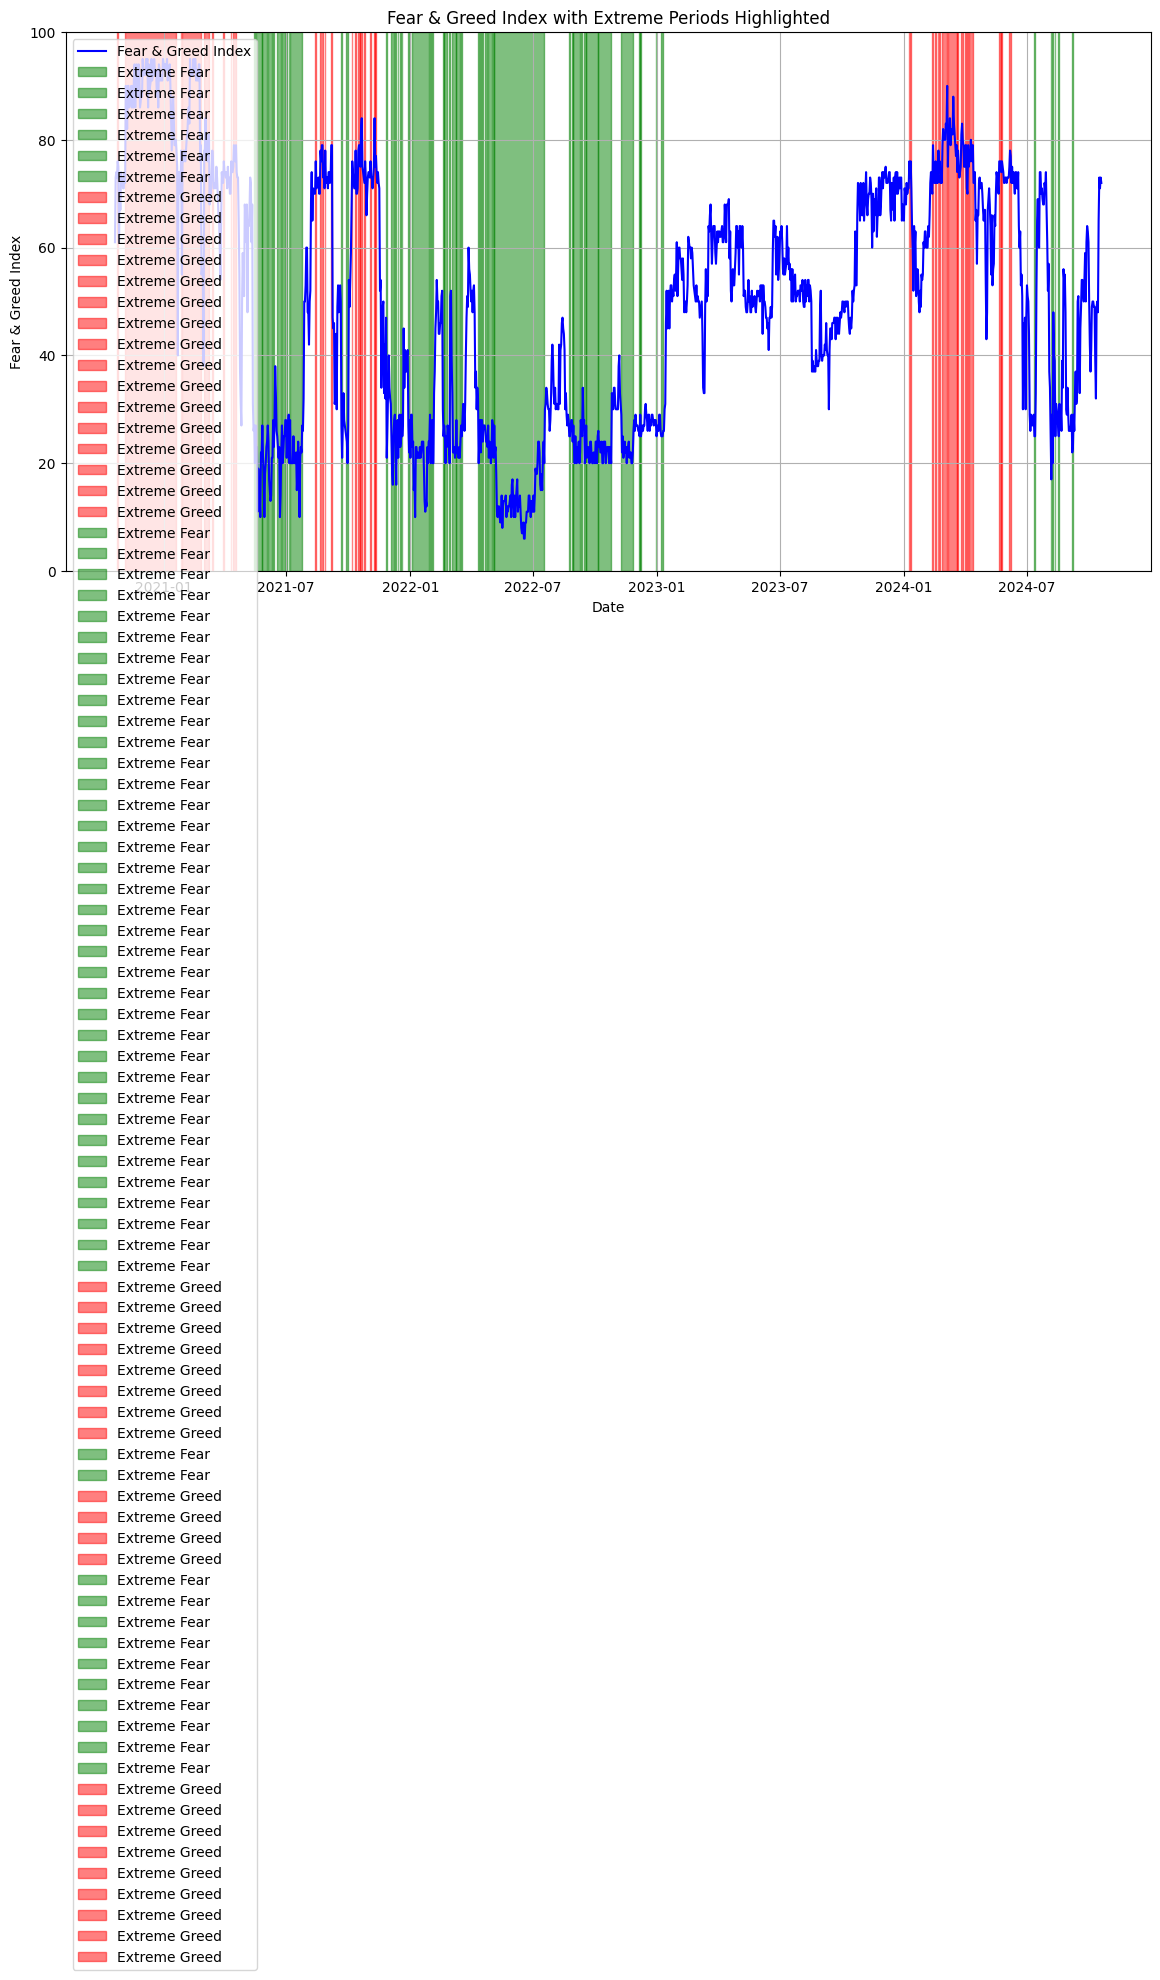

In [230]:
import matplotlib.pyplot as plt

def plot_extreme_periods(df, extreme_periods):
    plt.figure(figsize=(14, 7))

    # Plot the Fear & Greed Index
    plt.plot(df['date'], df['value'], label='Fear & Greed Index', color='blue')

    # Highlight extreme periods
    for period in extreme_periods:
        sentiment, start_date, end_date, duration = period
        plt.axvspan(start_date, end_date, color='red' if sentiment == 'Extreme Greed' else 'green', alpha=0.5, label=sentiment)

    plt.title('Fear & Greed Index with Extreme Periods Highlighted')
    plt.xlabel('Date')
    plt.ylabel('Fear & Greed Index')
    plt.ylim(0, 100)
    plt.legend()
    plt.grid()
    plt.show()

# Calculate extreme periods
extreme_periods = calculate_extreme_periods(fear_greed_df.sort_values('date',ascending=True))

# Plot the extreme periods
plot_extreme_periods(fear_greed_df, extreme_periods)

In [280]:
fig = plot_data_with_fear_greed_alerts(merged_bitcoin_fg_df, "BTC")
fig.show()

In [292]:
bitcoin_df = get_bitcoin_price_data(365*4)
bitcoin_df.sort_values('date',ascending=False).head()


,date,daily_min_price,daily_max_price,daily_avg_price,MA_125
1459,2024-10-18,67078.239586,68996.206107,68422.811066,61619.715317
1458,2024-10-17,67720.218800,67925.209699,67400.599237,61601.824904
1457,2024-10-16,67059.454112,68397.512858,67606.913200,61590.721043
1456,2024-10-15,66061.173282,67847.486348,67060.216610,61583.949754
1455,2024-10-14,62843.483252,66490.024460,66058.739874,61593.424383


In [258]:
merged_bitcoin_fg_df.head(10)

,date,value_classification,value,daily_min_price,daily_max_price,daily_avg_price
0,2024-10-18,Greed,73,67078.239586,68996.206107,68422.811066
1,2024-10-17,Greed,71,67720.218800,67925.209699,67400.599237
2,2024-10-16,Greed,73,67059.454112,68397.512858,67606.913200
3,2024-10-15,Greed,65,66061.173282,67847.486348,67060.216610
4,2024-10-14,Neutral,48,62843.483252,66490.024460,66058.739874
5,2024-10-13,Neutral,50,63192.246601,63270.760628,62848.614521
6,2024-10-12,Neutral,49,62503.854608,63463.994774,63190.360052
7,2024-10-11,Fear,32,60276.345304,63410.904839,62504.147692
8,2024-10-10,Fear,39,60582.289664,61247.267496,60275.775938
9,2024-10-09,Neutral,49,62121.999387,62507.828945,60580.449740


In [266]:
def merge_data(fear_greed_df, eth_df):
    # Merge the two DataFrames on the 'timestamp' column
    merged_df = pd.merge(fear_greed_df, eth_df, on='date', how='inner')
    return merged_df

In [218]:
def plot_data_with_fear_greed_alerts(merged_df, symbol):
    # Sort the dataframe by date
    merged_df = merged_df.sort_values('date')

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add cryptocurrency price trace
    fig.add_trace(
        go.Scatter(x=merged_df['date'], y=merged_df['daily_avg_price'], name=f"{symbol} Price", line=dict(color='blue')),
        secondary_y=False,
    )

    # Add Fear & Greed Index trace
    fig.add_trace(
        go.Scatter(x=merged_df['date'], y=merged_df['value'], name="Fear & Greed Index", line=dict(color='black', width=2)),
        secondary_y=True,
    )

    # Add colored background for different index ranges
    fig.add_hrect(y0=0, y1=25, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=25, y1=45, line_width=0, fillcolor="orange", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=45, y1=55, line_width=0, fillcolor="yellow", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=55, y1=75, line_width=0, fillcolor="lightgreen", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=75, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add alert zones
    fig.add_hrect(y0=0, y1=20, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=80, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add annotations for alert zones
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=10, text="Extreme Fear Zone", showarrow=False, font=dict(color="green"), yref="y2")
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=90, text="Extreme Greed Zone", showarrow=False, font=dict(color="red"), yref="y2")

    # Update layout
    fig.update_layout(
        title_text=f"Crypto Fear & Greed Index vs {symbol} Price with Alert Zones",
        xaxis_title="Date",
        yaxis_title=f"{symbol} Price (USD)",
        yaxis2_title="Fear & Greed Index",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        hovermode="x unified"
    )

    # Update y-axes ranges
    fig.update_yaxes(range=[merged_df['daily_avg_price'].min() * 0.8, merged_df['daily_avg_price'].max() * 1.2], secondary_y=False)
    fig.update_yaxes(range=[0, 100], tickvals=[0, 20, 40, 60, 80, 100],
                     ticktext=['0<br>Extreme<br>Fear', '20', '40', '60', '80', '100<br>Extreme<br>Greed'],
                     secondary_y=True)

    return fig



In [300]:
time_period = 365*4
bitcoin_df = get_bitcoin_price_data(time_period)  # Last 120 days
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])
bitcoin_df['date'] = pd.to_datetime(bitcoin_df['date'])


merged_bitcoin_fg_df = merge_data(fear_greed_df, bitcoin_df)



In [301]:
merged_bitcoin_fg_df.head()

,date,value_classification,value,daily_min_price,daily_max_price,daily_avg_price,MA_125
0,2024-10-18,Greed,73,67078.239586,68996.206107,68422.811066,61619.715317
1,2024-10-17,Greed,71,67720.218800,67925.209699,67400.599237,61601.824904
2,2024-10-16,Greed,73,67059.454112,68397.512858,67606.913200,61590.721043
3,2024-10-15,Greed,65,66061.173282,67847.486348,67060.216610,61583.949754
4,2024-10-14,Neutral,48,62843.483252,66490.024460,66058.739874,61593.424383


In [285]:
fig = plot_data_with_fear_greed_alerts(merged_bitcoin_fg_df, "BTC")
fig.show()

In [284]:
def plot_data_with_fear_greed_alerts(merged_df, symbol):
    # Sort the dataframe by date
    merged_df = merged_df.sort_values('date')

    # Calculate the 125-day moving average
    merged_df['MA_125'] = merged_df['daily_avg_price'].rolling(window=125).mean()

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add cryptocurrency price trace
    fig.add_trace(
        go.Scatter(x=merged_df['date'], y=merged_df['daily_avg_price'], name=f"{symbol} Price", line=dict(color='blue')),
        secondary_y=False,
    )

    # Add Fear & Greed Index trace
    fig.add_trace(
        go.Scatter(x=merged_df['date'], y=merged_df['value'], name="Fear & Greed Index", line=dict(color='black', width=2)),
        secondary_y=True,
    )

    # Add 125-day Moving Average trace
    fig.add_trace(
        go.Scatter(x=merged_df['date'], y=merged_df['MA_125'], name="MA (125)", line=dict(color='purple', width=2, dash='dash')),
        secondary_y=False,
    )

    # Add colored background for different index ranges
    fig.add_hrect(y0=0, y1=25, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=25, y1=45, line_width=0, fillcolor="orange", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=45, y1=55, line_width=0, fillcolor="yellow", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=55, y1=75, line_width=0, fillcolor="lightgreen", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=75, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add alert zones
    fig.add_hrect(y0=0, y1=20, line_width=0, fillcolor="green", opacity=0.2, secondary_y=True)
    fig.add_hrect(y0=80, y1=100, line_width=0, fillcolor="red", opacity=0.2, secondary_y=True)

    # Add annotations for alert zones
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=10, text="Extreme Fear Zone", showarrow=False, font=dict(color="green"), yref="y2")
    fig.add_annotation(x=merged_df['date'].iloc[-1], y=90, text="Extreme Greed Zone", showarrow=False, font=dict(color="red"), yref="y2")

    # Update layout
    fig.update_layout(
        title_text=f"Crypto Fear & Greed Index vs {symbol} Price with Alert Zones",
        xaxis_title="Date",
        yaxis_title=f"{symbol} Price (USD)",
        yaxis2_title="Fear & Greed Index",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        hovermode="x unified"
    )

    # Update y-axes ranges
    fig.update_yaxes(range=[merged_df['daily_avg_price'].min() * 0.8, merged_df['daily_avg_price'].max() * 1.2], secondary_y=False)
    fig.update_yaxes(range=[0, 100], tickvals=[0, 20, 40, 60, 80, 100],
                     ticktext=['0<br>Extreme<br>Fear', '20', '40', '60', '80', '100<br>Extreme<br>Greed'],
                     secondary_y=True)

    return fig

In [118]:
eth_df = get_eth_price_data(time_period)  # Last 120 days
merged_eth_fg_df = merge_data(fear_greed_df, eth_df)
fig = plot_data_with_fear_greed_alerts(merged_eth_fg_df, "ETH")
fig.show()


In [277]:
def trading_strategy_buy_and_sell(symbol,df,initial_investment):
    # Initialize variables
    df = df.sort_values('date')
    held = 0
    usd_balance = initial_investment
    trades = []
    # df['MA'] = df['daily_avg_price'].rolling(window=60).mean()
    
    for index, row in df.iterrows():
        date = row['date']
        price = row['daily_avg_price']
        index = row['value']
        sentiment = row['value_classification']
        # ma = row['MA']
        profit = 0
        extreme_greed_days = 0

        if sentiment == 'Extreme Fear' and usd_balance != 0:
            # Buy Bitcoin
            # if index < 20:
            #     usd_balance += 500
            to_buy = usd_balance / price
            held += to_buy
            trades.append(f"Buy: {date}, amount: ${usd_balance:.2f}, Price: ${price:.2f}, {symbol}: {to_buy:.6f}, Sentiment: {index}, {sentiment}")
            usd_balance = 0
        
        elif sentiment == 'Extreme Greed':
            extreme_greed_days += 1  # Increment counter for extreme greed
            if extreme_greed_days > 3 and held > 0:  # Check if we should sell
                usd_balance = held * price
                sell_trades.append(f"Sell: {date}, amount: ${usd_balance:.2f}, Price: ${price:.2f}, {symbol}: {held:.6f}")
                held = 0  # Reset held amount after selling
                extreme_greed_days = 0  # Reset counter after selling
        else:
            extreme_greed_days = 0
        

    # Calculate final portfolio value
    if held != 0:
        final_value = (held * df.iloc[-1]['daily_avg_price'])
    else:
        final_value = usd_balance

    return trades, held,final_value,initial_investment

# Run the strategy
symbol = "BTC"
investment_amount = 1000
trades, held,final_value,initial_investment = trading_strategy_buy_and_sell(symbol,merged_bitcoin_fg_df,initial_investment)

# Print results
print(f"{symbol}: only buy when sentiment is Extreme Fear")
print(f"Number of trades: {len(trades)}")
print(f"Bought: {held:.6f} {symbol}")
print(f"final_btc_price: ${merged_bitcoin_fg_df.sort_values('date').iloc[-1]['daily_avg_price']:.2f}")
print(f"Initial investment: ${initial_investment:.2f}")
print(f"Final portfolio value: ${final_value:.2f}")
print(f"Profit: ${final_value - initial_investment:.2f}")
annualized_return = ((final_value / initial_investment) ** (365 / len(merged_bitcoin_fg_df))) - 1
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print("\nTrade History:")
for trade in trades:
    print(trade)

print("\nSell Trade History:")
for trade in sell_trades:
    print(trade)



BTC: only buy when sentiment is Extreme Fear
Number of trades: 1
Bought: 0.215272 BTC
final_btc_price: $68422.81
Initial investment: $10000.00
Final portfolio value: $14729.50
Profit: $4729.50
Annualized Return: 10.17%

Trade History:
Buy: 2021-05-16 00:00:00, amount: $10000.00, Price: $46452.90, BTC: 0.215272, Sentiment: 20, Extreme Fear

Sell Trade History:
Sell: 2024-02-17, Price: $51662.47, BTC: 1.634199, Total Value: $84426.77


In [271]:
symbol = "ETH"
investment_amount = 1000
trades, held,final_value,total_investment = trading_strategy_buy_and_hold(symbol,merged_eth_fg_df,investment_amount)

# Print results
print(f"{symbol}: only buy when sentiment is Extreme Fear")
print(f"Number of trades: {len(trades)}")
print(f"Bought: {held:.6f} {symbol}")
print(f"final_eth_price: ${merged_eth_fg_df.sort_values('date').iloc[-1]['daily_avg_price']:.2f}")
print(f"Total investment: ${total_investment:.2f}")
print(f"Final portfolio value: ${final_value:.2f}")
print(f"Profit: ${final_value - total_investment:.2f}")
annualized_return = ((final_value / total_investment) ** (365 / len(merged_eth_fg_df))) - 1
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print("\nTrade History:")
for trade in trades:
    print(trade)


ETH: only buy when sentiment is Extreme Fear
Number of trades: 290
Bought: 160.700370 ETH
final_eth_price: $2414.56
Total investment: $290000.00
Final portfolio value: $388019.99
Profit: $98019.99
Annualized Return: 7.56%

Trade History:
Buy: 2021-05-16, usd_balance: $1000.00, Price: $3584.54, ETH: 0.278976, Sentiment: 20, Extreme Fear
Buy: 2021-05-18, usd_balance: $1000.00, Price: $3376.88, ETH: 0.296131, Sentiment: 21, Extreme Fear
Buy: 2021-05-19, usd_balance: $1000.00, Price: $2442.99, ETH: 0.409334, Sentiment: 23, Extreme Fear
Buy: 2021-05-20, usd_balance: $1000.00, Price: $2774.10, ETH: 0.360477, Sentiment: 11, Extreme Fear
Buy: 2021-05-21, usd_balance: $1000.00, Price: $2434.74, ETH: 0.410721, Sentiment: 19, Extreme Fear
Buy: 2021-05-22, usd_balance: $1000.00, Price: $2298.79, ETH: 0.435012, Sentiment: 12, Extreme Fear
Buy: 2021-05-23, usd_balance: $1000.00, Price: $2099.67, ETH: 0.476266, Sentiment: 14, Extreme Fear
Buy: 2021-05-24, usd_balance: $1000.00, Price: $2650.79, ETH: 

In [343]:
def trading_strategy_buy_and_hold(symbol,df,investment_amount):
    # Initialize variables
    df = df.sort_values('date')
    held = 0
    total_investment = 0
    trades = []
    # df['MA'] = df['daily_avg_price'].rolling(window=60).mean()
    
    for index, row in df.iterrows():
        date = row['date']
        price = row['daily_avg_price']
        index = row['value']
        sentiment = row['value_classification']
        # ma = row['MA']

        if sentiment == 'Extreme Fear':
            # Buy Bitcoin
            usd_balance = investment_amount 
            # if index < 20:
            #     usd_balance += 500
                
            to_buy = usd_balance / price
            held += to_buy
            trades.append(f"Buy: {date}, usd_balance: ${usd_balance:.2f}, Price: ${price:.2f}, {symbol}: {to_buy:.6f}, Sentiment: {index}, {sentiment}")
            total_investment += usd_balance
        

    # Calculate final portfolio value
    final_value = (held * df.iloc[-1]['daily_avg_price'])

    return trades, held,final_value,total_investment

# Run the strategy
symbol = "BTC"
investment_amount = 1000
trades, held,final_value,total_investment = trading_strategy_buy_and_hold(symbol,merged_bitcoin_fg_df,investment_amount)

# Print results
print(f"{symbol}: only buy when sentiment is Extreme Fear")
print(f"Number of trades: {len(trades)}")
print(f"Bought: {held:.6f} {symbol}")
print(f"Total investment: ${total_investment:.2f}")
print(f"Final portfolio value: ${final_value:.2f}")
print(f"Profit: ${final_value - total_investment:.2f}")
annualized_return = ((final_value / total_investment) ** (365 / len(merged_bitcoin_fg_df))) - 1
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print("\nTrade History:")
for trade in trades:
    print(trade)



BTC: only buy when sentiment is Extreme Fear
Number of trades: 290
Bought: 10.649999 BTC
Total investment: $290000.00
Final portfolio value: $728702.87
Profit: $438702.87
Annualized Return: 25.92%

Trade History:
Buy: 2021-05-16 00:00:00, usd_balance: $1000.00, Price: $46452.90, BTC: 0.021527, Sentiment: 20, Extreme Fear
Buy: 2021-05-18 00:00:00, usd_balance: $1000.00, Price: $42891.97, BTC: 0.023314, Sentiment: 21, Extreme Fear
Buy: 2021-05-19 00:00:00, usd_balance: $1000.00, Price: $36744.67, BTC: 0.027215, Sentiment: 23, Extreme Fear
Buy: 2021-05-20 00:00:00, usd_balance: $1000.00, Price: $40610.33, BTC: 0.024624, Sentiment: 11, Extreme Fear
Buy: 2021-05-21 00:00:00, usd_balance: $1000.00, Price: $37322.78, BTC: 0.026793, Sentiment: 19, Extreme Fear
Buy: 2021-05-22 00:00:00, usd_balance: $1000.00, Price: $37525.34, BTC: 0.026649, Sentiment: 12, Extreme Fear
Buy: 2021-05-23 00:00:00, usd_balance: $1000.00, Price: $34728.05, BTC: 0.028795, Sentiment: 14, Extreme Fear
Buy: 2021-05-24 0

In [341]:
def trading_strategy_buy_and_hold_ma(symbol,df,investment_amount):
    # Initialize variables
    df = df.sort_values('date')
    held = 0
    total_investment = 0
    trades = []
    # df['MA'] = df['daily_avg_price'].rolling(window=60).mean()
    
    for index, row in df.iterrows():
        date = row['date']
        price = row['daily_avg_price']
        index = row['value']
        sentiment = row['value_classification']
        ma125_price = row['MA_125']
        # ma = row['MA']

        if index < 20 and price < ma125_price * 0.9:
            # Buy Bitcoin
            usd_balance = investment_amount 
            if price < ma125_price * 0.8:
                usd_balance += 500
                
            to_buy = usd_balance / price
            held += to_buy
            trades.append(f"Buy: {date}, usd_balance: ${usd_balance:.2f}, Price: ${price:.2f}, {symbol}: {to_buy:.6f}, MA125 : {ma125_price},Sentiment: {index}, {sentiment}")
            total_investment += usd_balance
        

    # Calculate final portfolio value
    final_value = (held * df.iloc[-1]['daily_avg_price'])

    return trades, held,final_value,total_investment

# Run the strategy
symbol = "BTC"
investment_amount = 1000
trades, held,final_value,total_investment = trading_strategy_buy_and_hold_ma(symbol,merged_bitcoin_fg_df,investment_amount)

# Print results
print(f"{symbol}: only buy when sentiment is Extreme Fear")
print(f"Number of trades: {len(trades)}")
print(f"Bought: {held:.6f} {symbol}")
print(f"Total investment: ${total_investment:.2f}")
print(f"Final portfolio value: ${final_value:.2f}")
print(f"Profit: ${final_value - total_investment:.2f}")
annualized_return = ((final_value / total_investment) ** (365 / len(merged_bitcoin_fg_df))) - 1
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print("\nTrade History:")
for trade in trades:
    print(trade)



BTC: only buy when sentiment is Extreme Fear
Number of trades: 92
Bought: 4.939597 BTC
Total investment: $134000.00
Final portfolio value: $337981.11
Profit: $203981.11
Annualized Return: 26.04%

Trade History:
Buy: 2021-05-20 00:00:00, usd_balance: $1000.00, Price: $40610.33, BTC: 0.024624, MA125 : 50287.222249258935,Sentiment: 11, Extreme Fear
Buy: 2021-05-21 00:00:00, usd_balance: $1500.00, Price: $37322.78, BTC: 0.040190, MA125 : 50297.75105900474,Sentiment: 19, Extreme Fear
Buy: 2021-05-22 00:00:00, usd_balance: $1500.00, Price: $37525.34, BTC: 0.039973, MA125 : 50311.071446862996,Sentiment: 12, Extreme Fear
Buy: 2021-05-23 00:00:00, usd_balance: $1500.00, Price: $34728.05, BTC: 0.043193, MA125 : 50295.573251151145,Sentiment: 14, Extreme Fear
Buy: 2021-05-24 00:00:00, usd_balance: $1500.00, Price: $38835.24, BTC: 0.038625, MA125 : 50318.987596105224,Sentiment: 10, Extreme Fear
Buy: 2021-05-29 00:00:00, usd_balance: $1500.00, Price: $34606.75, BTC: 0.043344, MA125 : 50500.755364732

In [342]:
fig = plot_data_with_fear_greed_alerts(merged_bitcoin_fg_df, "BTC")
fig.show()

In [ ]:
extreme_periods

[('Extreme Fear',
  datetime.date(2022, 10, 21),
  datetime.date(2022, 10, 26),
  5,
  19165.5170916904,
  20084.7744306653),
 ('Extreme Fear',
  datetime.date(2022, 11, 10),
  datetime.date(2022, 11, 27),
  17,
  15760.2485700746,
  17563.6903246358),
 ('Extreme Fear',
  datetime.date(2022, 12, 6),
  datetime.date(2022, 12, 7),
  1,
  17087.2182285305,
  17087.2182285305),
 ('Extreme Fear',
  datetime.date(2022, 12, 8),
  datetime.date(2022, 12, 9),
  1,
  17225.2070553596,
  17225.2070553596),
 ('Extreme Fear',
  datetime.date(2022, 12, 31),
  datetime.date(2023, 1, 1),
  1,
  16532.3084626807,
  16532.3084626807),
 ('Extreme Fear',
  datetime.date(2023, 1, 7),
  datetime.date(2023, 1, 10),
  3,
  16940.3580686206,
  17179.8257063863),
 ('Extreme Greed',
  datetime.date(2024, 1, 9),
  datetime.date(2024, 1, 10),
  1,
  46124.078715583,
  46124.078715583),
 ('Extreme Greed',
  datetime.date(2024, 1, 11),
  datetime.date(2024, 1, 12),
  1,
  46343.2023845144,
  46343.2023845144),
 ('Ex

In [349]:
def trading_strategy_buy_and_sell_ma(symbol, df, initial_investment):
    # Initialize variables
    df = df.sort_values('date')
    held = 0
    usd_balance = initial_investment
    trades = []
    sell_trades = []  # To track sell trades
    # df['MA'] = df['daily_avg_price'].rolling(window=20).mean()
    extreme_greed_days = 0  # Counter for extreme greed days

    for index, row in df.iterrows():
        date = row['date']
        price = row['daily_avg_price']
        index = row['value']
        sentiment = row['value_classification']
        ma125_price = row['MA_125']
        # ma = row['MA']

        if index < 20 and price < ma125_price * 0.7 and usd_balance != 0:
        # Buy Bitcoin
            to_buy = usd_balance / price
            held += to_buy
            trades.append(f"Buy: {date}, Investment_Amount: ${usd_balance:.2f}, Price: ${price:.2f}, {symbol}: {to_buy:.6f}, MA125 : {ma125_price},Sentiment: {index}, {sentiment}")
            usd_balance = 0

        elif sentiment == 'Extreme Greed' and price > ma125_price * 1.3:
            extreme_greed_days += 1  # Increment counter for extreme greed
            if extreme_greed_days > 3 and held > 0:  # Check if we should sell
                sell_value = held * price
              
                usd_balance = sell_value  # Update total investment with sell value
                 
                held = 0  # Reset held amount after selling
                trades.append(f"Sell: {date}, Sold_Amount: ${usd_balance:.2f}, Price: ${price:.2f}, {symbol}: {held:.6f}, usd_balance: ${sell_value:.2f}, MA125 : {ma125_price} ,Sentiment: {index}, {sentiment}")
                extreme_greed_days = 0  # Reset counter after selling

    # Calculate final portfolio value
    if held != 0:
        final_value = (held * df.iloc[-1]['daily_avg_price'])
    else:
        final_value = usd_balance

    return trades, held, final_value, initial_investment

# Run the strategy
symbol = "BTC"
investment_amount = 10000
trades, held, final_value, initial_investment = trading_strategy_buy_and_sell_ma(symbol, merged_bitcoin_fg_df, investment_amount)

# Print results
print(f"{symbol}: only buy when sentiment is Extreme Fear and price is less than MA")
print(f"Number of buy trades: {len(trades)}")
print(f"Number of sell trades: {len(sell_trades)}")
print(f"Bought: {held:.6f} {symbol}")
print(f"Final portfolio value: ${final_value:.2f}")
print(f"Profit: ${final_value - initial_investment:.2f}")
annualized_return = ((final_value / initial_investment) ** (365 / len(merged_bitcoin_fg_df))) - 1
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print("\nBuy Trade History:")
for trade in trades:
    print(trade)

BTC: only buy when sentiment is Extreme Fear and price is less than MA
Number of buy trades: 4
Number of sell trades: 3
Bought: 0.000000 BTC
Final portfolio value: $19596.20
Profit: $9596.20
Annualized Return: 18.33%

Buy Trade History:
Buy: 2021-05-23 00:00:00, Investment_Amount: $10000.00, Price: $34728.05, BTC: 0.287952, MA125 : 50295.573251151145,Sentiment: 14, Extreme Fear
Sell: 2021-10-07 00:00:00, Sold_Amount: $15491.70, Price: $53799.66, BTC: 0.000000, usd_balance: $15491.70, MA125 : 41129.29658144776 ,Sentiment: 76, Extreme Greed
Buy: 2022-01-21 00:00:00, Investment_Amount: $15491.70, Price: $36463.22, BTC: 0.424858, MA125 : 52513.492356228766,Sentiment: 19, Extreme Fear
Sell: 2024-01-09 00:00:00, Sold_Amount: $19596.20, Price: $46124.08, BTC: 0.000000, usd_balance: $19596.20, MA125 : 34998.95338686573 ,Sentiment: 76, Extreme Greed


In [115]:
def trading_strategy_buy_and_hold(symbol,df,investment_amount):
    # Initialize variables
    df = df.sort_values('date')
    held = 0
    total_investment = 0
    trades = []
    # df['MA'] = df['daily_avg_price'].rolling(window=60).mean()
    
    for index, row in df.iterrows():
        date = row['date']
        price = row['daily_avg_price']
        index = row['value']
        sentiment = row['value_classification']
        # ma = row['MA']

        if sentiment == 'Extreme Fear':
            # Buy Bitcoin
            usd_balance = investment_amount 
            # if index < 20:
            #     usd_balance += 500
                
            to_buy = usd_balance / price
            held += to_buy
            trades.append(f"Buy: {date}, usd_balance: ${usd_balance:.2f}, Price: ${price:.2f}, {symbol}: {to_buy:.6f}, Sentiment: {index}, {sentiment}")
            total_investment += usd_balance
        

    # Calculate final portfolio value
    final_value = (held * df.iloc[-1]['daily_avg_price'])

    return trades, held,final_value,total_investment

# Run the strategy
symbol = "BTC"
investment_amount = 1000
trades, held,final_value,total_investment = trading_strategy_buy_and_hold(symbol,merged_bitcoin_fg_df,investment_amount)

# Print results
print(f"{symbol}: only buy when sentiment is Extreme Fear")
print(f"Number of trades: {len(trades)}")
print(f"Bought: {held:.6f} {symbol}")
print(f"Total investment: ${total_investment:.2f}")
print(f"final_btc_price: ${merged_bitcoin_fg_df.sort_values('date').iloc[-1]['daily_avg_price']:.2f}")
print(f"Final portfolio value: ${final_value:.2f}")
print(f"Profit: ${final_value - total_investment:.2f}")
annualized_return = ((final_value / total_investment) ** (365 / len(merged_bitcoin_fg_df))) - 1
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print("\nTrade History:")
for trade in trades:
    print(trade)



BTC: only buy when sentiment is Extreme Fear
Number of trades: 290
Bought: 10.649999 BTC
Total investment: $290000.00
final_btc_price: $62056.42
Final portfolio value: $660900.83
Profit: $370900.83
Annualized Return: 22.88%

Trade History:
Buy: 2021-05-16, usd_balance: $1000.00, Price: $46452.90, BTC: 0.021527, Sentiment: 20, Extreme Fear
Buy: 2021-05-18, usd_balance: $1000.00, Price: $42891.97, BTC: 0.023314, Sentiment: 21, Extreme Fear
Buy: 2021-05-19, usd_balance: $1000.00, Price: $36744.67, BTC: 0.027215, Sentiment: 23, Extreme Fear
Buy: 2021-05-20, usd_balance: $1000.00, Price: $40610.33, BTC: 0.024624, Sentiment: 11, Extreme Fear
Buy: 2021-05-21, usd_balance: $1000.00, Price: $37322.78, BTC: 0.026793, Sentiment: 19, Extreme Fear
Buy: 2021-05-22, usd_balance: $1000.00, Price: $37525.34, BTC: 0.026649, Sentiment: 12, Extreme Fear
Buy: 2021-05-23, usd_balance: $1000.00, Price: $34728.05, BTC: 0.028795, Sentiment: 14, Extreme Fear
Buy: 2021-05-24, usd_balance: $1000.00, Price: $38835

In [113]:
merged_bitcoin_fg_df.head()
merged_bitcoin_fg_df.sort_values('date').iloc[-1]['daily_avg_price']

np.float64(62056.4222048493)

In [315]:
def trading_strategy_buy_and_hold(symbol,df,investment_amount):
    # Initialize variables
    df = df.sort_values('date')
    held = 0
    total_investment = 0
    trades = []
    df['MA'] = df['daily_avg_price'].rolling(window=20).mean()
    
    for index, row in df.iterrows():
        date = row['date']
        price = row['daily_avg_price']
        index = row['value']
        sentiment = row['value_classification']
        ma = row['MA']

        if sentiment == 'Extreme Fear' and price < ma:
            # Buy Bitcoin
            if index < 20:
                investment_amount += 500
            usd_balance = investment_amount  # Starting with $10,000
            to_buy = usd_balance / price
            held += to_buy
            trades.append(f"Buy: {date}, usd_balance: ${usd_balance:.2f}, Price: ${price:.2f}, {symbol}: {to_buy:.6f}, MA: {ma:.2f}, Sentiment: {index}, {sentiment}")
            total_investment += usd_balance
            usd_balance = 0
            

    # Calculate final portfolio value
    final_value = (held * df.iloc[-1]['daily_avg_price'])

    return trades, held,final_value,total_investment

# Run the strategy
symbol = "BTC"
investment_amount = 1000
trades, held,final_value,total_investment = trading_strategy_buy_and_hold(symbol,merged_bitcoin_fg_df,investment_amount)

# Print results
print(f"{symbol}: only buy when sentiment is Extreme Fear and price is less than MA")
print(f"Number of trades: {len(trades)}")
print(f"Bought: {held:.6f} {symbol}")
print(f"Total investment: ${total_investment:.2f}")
print(f"Final portfolio value: ${final_value:.2f}")
print(f"Profit: ${final_value - total_investment:.2f}")
annualized_return = ((final_value / total_investment) ** (365 / len(merged_bitcoin_fg_df))) - 1
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print("\nTrade History:")
for trade in trades:
    print(trade)



BTC: only buy when sentiment is Extreme Fear and price is less than MA
Number of trades: 240
Bought: -360.844238 BTC
Total investment: $-8839000.00
Final portfolio value: $-24689977.11
Profit: $-15850977.11
Annualized Return: 29.30%

Trade History:
Buy: 2021-05-16 00:00:00, usd_balance: $1000.00, Price: $46452.90, BTC: 0.021527, MA: 54511.01, Sentiment: 20, Extreme Fear
Buy: 2021-05-18 00:00:00, usd_balance: $500.00, Price: $42891.97, BTC: 0.011657, MA: 53336.01, Sentiment: 21, Extreme Fear
Buy: 2021-05-19 00:00:00, usd_balance: $0.00, Price: $36744.67, BTC: 0.000000, MA: 52494.93, Sentiment: 23, Extreme Fear
Buy: 2021-05-20 00:00:00, usd_balance: $0.00, Price: $40610.33, BTC: 0.000000, MA: 51640.37, Sentiment: 11, Extreme Fear
Buy: 2021-05-21 00:00:00, usd_balance: $0.00, Price: $37322.78, BTC: 0.000000, MA: 50615.78, Sentiment: 19, Extreme Fear
Buy: 2021-05-22 00:00:00, usd_balance: $0.00, Price: $37525.34, BTC: 0.000000, MA: 49662.40, Sentiment: 12, Extreme Fear
Buy: 2021-05-23 00:0

In [77]:
symbol = "ETH"
investment_amount = 1000
trades, held,final_value,total_investment = trading_strategy_buy_and_hold(symbol,merged_eth_fg_df,investment_amount)

# Print results
print(f"Symbol: {symbol}")
print(f"Number of trades: {len(trades)}")
print(f"Bought: {held:.6f} {symbol}")
print(f"Total investment: ${total_investment:.2f}")
print(f"Final portfolio value: ${final_value:.2f}")
print(f"Profit: ${final_value - total_investment:.2f}")
annualized_return = ((final_value / total_investment) ** (365 / len(merged_bitcoin_fg_df))) - 1
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print("\nTrade History:")
for trade in trades:
    print(trade)

Symbol: ETH
Number of trades: 257
Bought: 144.607816 ETH
Total investment: $257000.00
Final portfolio value: $349163.62
Profit: $92163.62
Annualized Return: 7.97%

Trade History:
Buy: 2021-05-19, Price: $2442.99, ETH: 0.409334, Sentiment: 23, Extreme Fear
Buy: 2021-05-21, Price: $2434.74, ETH: 0.410721, Sentiment: 19, Extreme Fear
Buy: 2021-05-22, Price: $2298.79, ETH: 0.435012, Sentiment: 12, Extreme Fear
Buy: 2021-05-23, Price: $2099.67, ETH: 0.476266, Sentiment: 14, Extreme Fear
Buy: 2021-05-28, Price: $2413.15, ETH: 0.414397, Sentiment: 21, Extreme Fear
Buy: 2021-05-29, Price: $2279.10, ETH: 0.438771, Sentiment: 18, Extreme Fear
Buy: 2021-05-30, Price: $2385.31, ETH: 0.419233, Sentiment: 10, Extreme Fear
Buy: 2021-05-31, Price: $2706.91, ETH: 0.369425, Sentiment: 18, Extreme Fear
Buy: 2021-06-01, Price: $2634.10, ETH: 0.379637, Sentiment: 20, Extreme Fear
Buy: 2021-06-02, Price: $2706.42, ETH: 0.369492, Sentiment: 23, Extreme Fear
Buy: 2021-06-05, Price: $2629.00, ETH: 0.380373, Se